In [3]:
using DrWatson
@quickactivate projectdir()

using CSV, DataFrames, Muon
using StatsPlots, StatsBase
theme(:default, grid=false, tickdir=:out, label="")

In [6]:
biobank = readh5mu(datadir("exp_pro", "BB669", "BB669.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/ben/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 669 ✕ 21485
└ metabolites_foldchange
  AnnData object 669 ✕ 50
└ metabolites_millimolar
  AnnData object 669 ✕ 10
└ UPorder_oggs
  AnnData object 669 ✕ 10177
└ oggs
  AnnData object 669 ✕ 11248

In [7]:
specieslabels = [
    "Bacteroides uniformis",
    "Phocaeicola vulgatus",
    "Bacteroides thetaiotaomicron",
    "[Ruminococcus] gnavus",
    "Bifidobacterium breve",
    "[Eubacterium] rectale",
    "Dorea formicigenerans",
    "Coprococcus comes",
    "Blautia luti & Blautia wexlerae",
    "Anaerostipes hadrus",
]
shapes = permutedims([:circle, :rect, :star5, :diamond, :hexagon, :ltriangle, :pentagon, :utriangle, :dtriangle, :rtriangle, :star4])
speciescolors = wload(datadir("exp_pro", "BB669", "subsettreecolors.jld2"))["colors"]
# speciescolors_ordered = permutedims(speciescolors[replace(indexin(sort(unique(biobank.obs.species)), specieslabels), nothing=>9)])

In [8]:
keptspecies = string.(keys(sort(filter(x-> last(x) > 19, countmap(biobank.obs.species)), byvalue=true, rev=true)))
filter!(!=("unclassified"), keptspecies)
full_train_mask = in.(biobank.obs.species, Ref(keptspecies));
full_test_mask = .!(full_train_mask);
bbobs_trn = biobank.obs[full_train_mask, :];

In [9]:
mskids_ofinterest = [
    "DFI.1.234",
    "DFI.2.45",
    "DFI.4.30",
    "DFI.6.27",
    "DFI.3.84",
    "DFI.5.40",
    "DFI.5.28",
]

7-element Vector{String}:
 "DFI.1.234"
 "DFI.2.45"
 "DFI.4.30"
 "DFI.6.27"
 "DFI.3.84"
 "DFI.5.40"
 "DFI.5.28"

In [10]:
existing_msks = mskids_ofinterest[.!isnothing.(indexin(mskids_ofinterest, bbobs_trn.ID))]

2-element Vector{String}:
 "DFI.4.30"
 "DFI.3.84"

In [11]:
oofpreds = CSV.read(projectdir("_research","metabolite_SLE_Lasso_model","oof_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=0.001.csv"), DataFrame);

In [12]:
existingrows = filter(!isnothing, indexin(mskids_ofinterest, bbobs_trn.ID))

2-element Vector{Union{Nothing, Int64}}:
 139
 140

In [13]:
bbobs_trn[existingrows, [:ID, :species]]

2×2 DataFrame
 Row │ ID        species             
     │ String    String              
─────┼───────────────────────────────
   1 │ DFI.4.30  Anaerostipes hadrus
   2 │ DFI.3.84  Coprococcus comes

In [14]:
labeldict = Dict(k=>v for (k,v) in zip(existingrows, existing_msks))

Dict{Int64, String} with 2 entries:
  139 => "DFI.4.30"
  140 => "DFI.3.84"

In [15]:
biobank["metabolites_foldchange"].obs_names[full_train_mask][existingrows]

2-element Vector{String}:
 "DFI.4.30"
 "DFI.3.84"

In [16]:
biobank["metabolites_foldchange"].X[:, 1][full_train_mask][existingrows]

2-element Vector{Float64}:
 0.02989673291368581
 2.993937385183651

In [17]:
pltdf = subset(oofpreds,
    :row_id => x->x.∈Ref(existingrows),
    :metabolite_name => x->x.=="Acetate",
) |>
df -> sort(df, :row_id)

10×6 DataFrame
 Row │ row_id  metabolite_name  fold   resample  truth      preds     
     │ Int64   String31         Int64  Int64     Float64    Float64   
─────┼────────────────────────────────────────────────────────────────
   1 │    139  Acetate              4         1  0.0298967  -1.36535
   2 │    139  Acetate              2         2  0.0298967  -0.730372
   3 │    139  Acetate              1         3  0.0298967  -2.15604
   4 │    139  Acetate              3         4  0.0298967  -0.710359
   5 │    139  Acetate              1         5  0.0298967  -0.719351
   6 │    140  Acetate              2         1  2.99394     1.5376
   7 │    140  Acetate              3         2  2.99394     1.57294
   8 │    140  Acetate              3         3  2.99394     1.53858
   9 │    140  Acetate              3         4  2.99394     1.51228
  10 │    140  Acetate              4         5  2.99394     1.55671

In [18]:
getlims(x) = x |> extrema |> x->abs.(x) |> maximum |> x-> (-x, x)

getlims (generic function with 1 method)

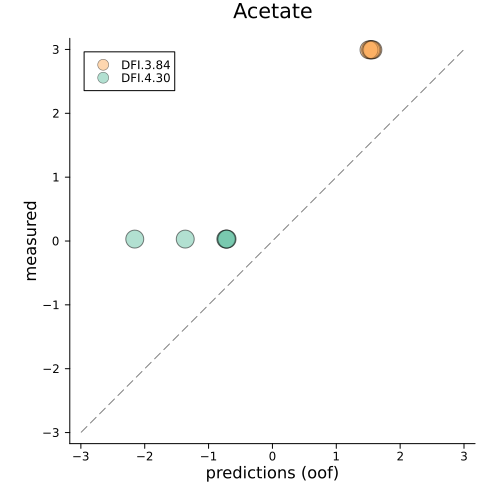

In [19]:
lims=getlims(vcat(pltdf.truth, pltdf.preds))
plot(;title="Acetate", xlabel="predictions (oof)", ylabel="measured", lims, widen=true)
plot!(identity, c=:grey, linestyle=:dash)
@df pltdf scatter!(:preds, :truth, group=getindex.(Ref(labeldict), :row_id),
    ratio=1, size=(500,500), markersize=10,
    alpha=.5, c=permutedims(speciescolors[[8, 10]]),
    
)

In [201]:
condf = CSV.read(datadir("exp_raw", "BBConsortia", "ConsortiaMetab.tsv"), DataFrame; delim="\t")

28×30 DataFrame
 Row │ CON_ID   Input_Condition             Exp_ID  Quant_Qual  Media    Ph    ⋯
     │ String7  String31                    Int64   String7     String7  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CON.119  taurochenodeoxycholic_acid      42  Quant       BHIM        6. ⋯
   2 │ CON.119  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
   3 │ CON.119  taurocholic_acid                41  Quant       BHIM        6.
   4 │ CON.119  taurocholic_acid                41  Quant       BHIM        6.
   5 │ CON.090  taurochenodeoxycholic_acid      42  Quant       BHIM        6. ⋯
   6 │ CON.090  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
   7 │ CON.090  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
   8 │ CON.090  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
  ⋮  │    ⋮                 ⋮                 ⋮         ⋮          ⋮        ⋮  ⋱
  22 │ CON.086  taurochenodeoxycholic_acid      42  Quant       BHIM        6. ⋯
  23 │ CON.086  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
  24 │ CON.086  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
  25 │ CON.086  taurocholic_acid                41  Quant       BHIM        6.
  26 │ CON.086  taurocholic_acid                41  Quant       BHIM        6. ⋯
  27 │ CON.086  taurocholic_acid                41  Quant       BHIM        6.
  28 │ CON.086  taurocholic_acid                41  Quant       BHIM        6.
                                                  25 columns and 13 rows omitted

In [202]:
con_log2fc_df = condf |>
df -> transform(df, 8:30 .=> x->max.(x, 0.), renamecols=false) |>
df -> stack(df, [:acetate, :butyrate, :propionate, :succinate]) |>
df -> transform(df, [:Compound, :variable] => ByRow((x,y)->(x * "_" * y)) => :Compound_metab) |>
df -> unstack(df, Cols(1:6), :Compound_metab, :value) |>
df -> transform(df,
    [:MetabValues_acetate, :BlankValues_acetate] => ByRow((x,y)->log2(x/y)) => :acetate,
    [:MetabValues_butyrate, :BlankValues_butyrate] => ByRow((x,y)->log2(x/y)) => :butyrate,
    [:MetabValues_propionate, :BlankValues_propionate] => ByRow((x,y)->log2(x/y)) => :propionate,
    [:MetabValues_succinate, :BlankValues_succinate] => ByRow((x,y)->log2(x/y)) => :succinate,
) |>
df -> select(df, [1:6..., 15:18...])

14×10 DataFrame
 Row │ CON_ID   Input_Condition             Exp_ID  Quant_Qual  Media    Ph    ⋯
     │ String7  String31                    Int64   String7     String7  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CON.119  taurochenodeoxycholic_acid      42  Quant       BHIM        6. ⋯
   2 │ CON.119  taurocholic_acid                41  Quant       BHIM        6.
   3 │ CON.090  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
   4 │ CON.090  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
   5 │ CON.090  taurocholic_acid                41  Quant       BHIM        6. ⋯
   6 │ CON.090  taurocholic_acid                41  Quant       BHIM        6.
   7 │ CON.084  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
   8 │ CON.084  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
   9 │ CON.084  taurocholic_acid                41  Quant       BHIM        6. ⋯
  10 │ CON.084  taurocholic_acid                41  Quant       BHIM        6.
  11 │ CON.086  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
  12 │ CON.086  taurochenodeoxycholic_acid      42  Quant       BHIM        6.
  13 │ CON.086  taurocholic_acid                41  Quant       BHIM        6. ⋯
  14 │ CON.086  taurocholic_acid                41  Quant       BHIM        6.
                                                               5 columns omitted

* CON.086: C. scindens (DFI1.234), B. longum (DFI.2.45), A. hadrus (DFI.4.30)-->acetate value of 0.6
* CON.119: C. scindens (DFI1.234), B. longum (DFI.2.45), E. rectale (DFI.6.27)-->acetate value of 9.43
* CON.084: C. scindens (DFI1.234), B. longum (DFI.2.45), C.comes (DFI.3.84)-->acetate value of 25.7
* CON.090: C. scindens (DFI1.234), B. longum (DFI.2.45), F. prausnitzii (DFI.5.40)-->acetate value of >30

In [203]:
msk_to_con_map = Dict("DFI.4.30" => "CON.086", "DFI.3.84" => "CON.084")

Dict{String, String} with 2 entries:
  "DFI.4.30" => "CON.086"
  "DFI.3.84" => "CON.084"

In [204]:
mskdf = subset(oofpreds,
    :row_id => x->x.∈Ref(existingrows),
    :metabolite_name => x->x.∈Ref(["Acetate", "Butyrate", "Propionate", "Succinate"]),
) |>
df -> unstack(df, [:row_id, :resample], :metabolite_name, :preds) |>
df -> sort(df, [:row_id, :resample])
mskdf.msk_id = bbobs_trn.ID[mskdf.row_id]
mskdf

10×7 DataFrame
 Row │ row_id  resample  Acetate    Butyrate  Propionate  Succinate  msk_id   
     │ Int64   Int64     Float64?   Float64?  Float64?    Float64?   String   
─────┼────────────────────────────────────────────────────────────────────────
   1 │    139         1  -1.36535    5.97668    2.96116   -1.22333   DFI.4.30
   2 │    139         2  -0.730372   5.92101    2.01425   -0.813426  DFI.4.30
   3 │    139         3  -2.15604    1.16823    0.321307  -1.41218   DFI.4.30
   4 │    139         4  -0.710359   5.94051    2.0256    -0.765429  DFI.4.30
   5 │    139         5  -0.719351   6.33553    2.54356   -0.541941  DFI.4.30
   6 │    140         1   1.5376     5.70944   -0.232188  -0.765692  DFI.3.84
   7 │    140         2   1.57294    5.65652   -0.23232   -0.765576  DFI.3.84
   8 │    140         3   1.53858    5.67505   -0.231366  -0.764807  DFI.3.84
   9 │    140         4   1.51228    5.65321   -0.230497  -0.784808  DFI.3.84
  10 │    140         5   1.55671    5.65997   -0.238907  -0.757101  DFI.3.84

In [205]:
basedf = DataFrame(con_id=[ "CON.086", "CON.084"], msk_id=["DFI.4.30", "DFI.3.84"])

2×2 DataFrame
 Row │ con_id   msk_id   
     │ String   String   
─────┼───────────────────
   1 │ CON.086  DFI.4.30
   2 │ CON.084  DFI.3.84

In [206]:
# tmpdf = DataFrame(;
#     con_id = get.(Ref(msk_to_con_map), bbobs_trn.ID[pltdf.row_id], ""),
#     msk_id = bbobs_trn.ID[pltdf.row_id],
# )
basedf = DataFrame(con_id=[ "CON.086", "CON.084"], msk_id=["DFI.4.30", "DFI.3.84"])
mrgdf = leftjoin(basedf, mskdf, on = :msk_id)
mrgdf = leftjoin(mrgdf, con_log2fc_df, on=:con_id=> :CON_ID)

40×17 DataFrame
 Row │ con_id   msk_id    row_id  resample  Acetate    Butyrate  Propionate  S ⋯
     │ String   String    Int64?  Int64?    Float64?   Float64?  Float64?    F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CON.084  DFI.3.84     140         1   1.5376     5.70944   -0.232188  - ⋯
   2 │ CON.084  DFI.3.84     140         2   1.57294    5.65652   -0.23232   -
   3 │ CON.084  DFI.3.84     140         3   1.53858    5.67505   -0.231366  -
   4 │ CON.084  DFI.3.84     140         4   1.51228    5.65321   -0.230497  -
   5 │ CON.084  DFI.3.84     140         5   1.55671    5.65997   -0.238907  - ⋯
   6 │ CON.084  DFI.3.84     140         1   1.5376     5.70944   -0.232188  -
   7 │ CON.084  DFI.3.84     140         2   1.57294    5.65652   -0.23232   -
   8 │ CON.084  DFI.3.84     140         3   1.53858    5.67505   -0.231366  -
  ⋮  │    ⋮        ⋮        ⋮        ⋮          ⋮         ⋮          ⋮         ⋱
  34 │ CON.086  DFI.4.30     139         4  -0.710359   5.94051    2.0256    - ⋯
  35 │ CON.086  DFI.4.30     139         5  -0.719351   6.33553    2.54356   -
  36 │ CON.086  DFI.4.30     139         1  -1.36535    5.97668    2.96116   -
  37 │ CON.086  DFI.4.30     139         2  -0.730372   5.92101    2.01425   -
  38 │ CON.086  DFI.4.30     139         3  -2.15604    1.16823    0.321307  - ⋯
  39 │ CON.086  DFI.4.30     139         4  -0.710359   5.94051    2.0256    -
  40 │ CON.086  DFI.4.30     139         5  -0.719351   6.33553    2.54356   -
                                                  10 columns and 25 rows omitted

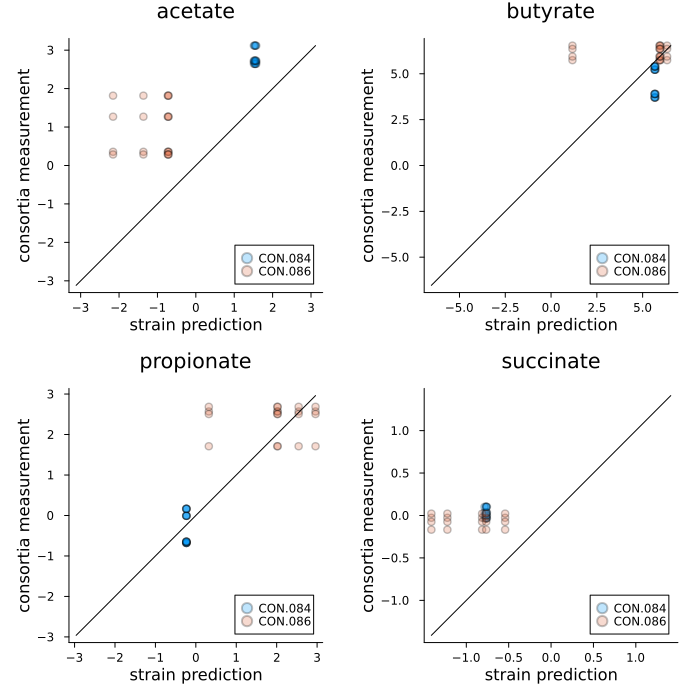

In [210]:
p1 = @df mrgdf scatter(:Acetate, :acetate, group=:con_id, alpha=.25, title="acetate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Acetate, mrgdf.acetate)), widen=true)
p2 = @df mrgdf scatter(:Butyrate, :butyrate, group=:con_id, alpha=.25, title="butyrate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Butyrate, mrgdf.butyrate)), widen=true)
p3 = @df mrgdf scatter(:Propionate, :propionate, group=:con_id, alpha=.25, title="propionate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Propionate, mrgdf.propionate)), widen=true)
p4 = @df mrgdf scatter(:Succinate, :succinate, group=:con_id, alpha=.25, title="succinate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Succinate, mrgdf.succinate)), widen=true, )
plot(p1, p2, p3, p4, layout = grid(2,2), size=(700,700), legend=:bottomright, xlabel="strain prediction", ylabel="consortia measurement")

In [211]:
pltdf = mrgdf |>
df -> groupby(df, :con_id) |>
df -> combine(df, 
    [5:8..., 14:17...] .=> mean,
    [5:8..., 14:17...] .=> std,
    )

2×17 DataFrame
 Row │ con_id   Acetate_mean  Butyrate_mean  Propionate_mean  Succinate_mean   ⋯
     │ String   Float64       Float64        Float64          Float64          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CON.084       1.54362        5.67084        -0.233056       -0.767597   ⋯
   2 │ CON.086      -1.13629        5.06839         1.97317        -0.95126
                                                              12 columns omitted

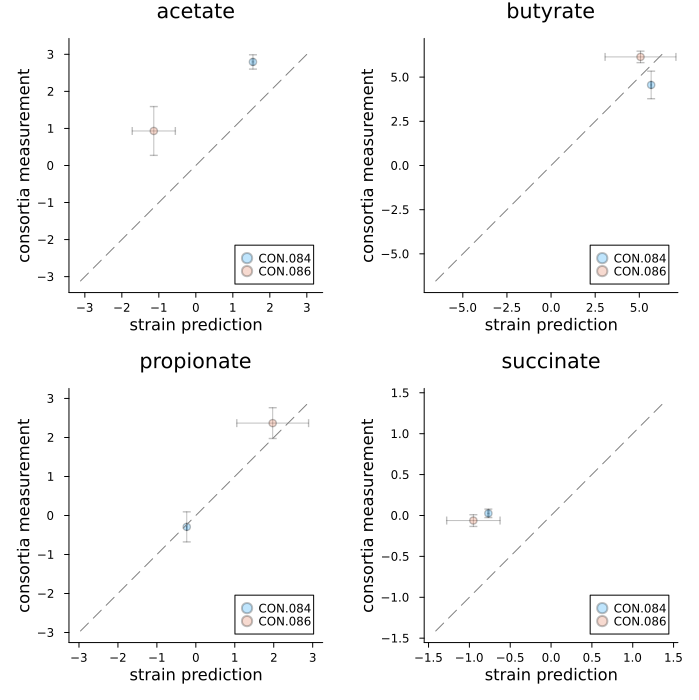

In [212]:
p1 = @df pltdf scatter(:Acetate_mean, :acetate_mean, xerror=:Acetate_std, yerror=:acetate_std, group=:con_id, alpha=.25, title="acetate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Acetate, mrgdf.acetate)), widen=1.1)
p2 = @df pltdf scatter(:Butyrate_mean, :butyrate_mean, xerror=:Butyrate_std, yerror=:butyrate_std, group=:con_id, alpha=.25, title="butyrate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Butyrate, mrgdf.butyrate)), widen=1.1)
p3 = @df pltdf scatter(:Propionate_mean, :propionate_mean, xerror=:Propionate_std, yerror=:propionate_std, group=:con_id, alpha=.25, title="propionate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Propionate, mrgdf.propionate)), widen=1.1)
p4 = @df pltdf scatter(:Succinate_mean, :succinate_mean, xerror=:Succinate_std, yerror=:succinate_std, group=:con_id, alpha=.25, title="succinate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Succinate, mrgdf.succinate)), widen=1.1)
plot(p1, p2, p3, p4, layout = grid(2,2), size=(700,700), legend=:bottomright, xlabel="strain prediction", ylabel="consortia measurement")

In [213]:
msk_to_con_map = Dict("DFI.4.30" => "CON.086", "DFI.3.84" => "CON.084")

Dict{String, String} with 2 entries:
  "DFI.4.30" => "CON.086"
  "DFI.3.84" => "CON.084"

In [214]:
mskdf = subset(oofpreds,
    :row_id => x->x.∈Ref(existingrows),
    :metabolite_name => x->x.∈Ref(["Acetate", "Butyrate", "Propionate", "Succinate"]),
) |>
df -> unstack(df, [:row_id, :resample], :metabolite_name, :truth) |>
df -> sort(df, [:row_id, :resample])
mskdf.msk_id = bbobs_trn.ID[mskdf.row_id]
mskdf

10×7 DataFrame
 Row │ row_id  resample  Acetate    Butyrate  Propionate  Succinate  msk_id   
     │ Int64   Int64     Float64?   Float64?  Float64?    Float64?   String   
─────┼────────────────────────────────────────────────────────────────────────
   1 │    139         1  0.0298967   7.10884    3.58584    0.13039   DFI.4.30
   2 │    139         2  0.0298967   7.10884    3.58584    0.13039   DFI.4.30
   3 │    139         3  0.0298967   7.10884    3.58584    0.13039   DFI.4.30
   4 │    139         4  0.0298967   7.10884    3.58584    0.13039   DFI.4.30
   5 │    139         5  0.0298967   7.10884    3.58584    0.13039   DFI.4.30
   6 │    140         1  2.99394     6.51655    0.407504   0.153073  DFI.3.84
   7 │    140         2  2.99394     6.51655    0.407504   0.153073  DFI.3.84
   8 │    140         3  2.99394     6.51655    0.407504   0.153073  DFI.3.84
   9 │    140         4  2.99394     6.51655    0.407504   0.153073  DFI.3.84
  10 │    140         5  2.99394     6.51655    0.407504   0.153073  DFI.3.84

In [215]:
basedf = DataFrame(con_id=[ "CON.086", "CON.084"], msk_id=["DFI.4.30", "DFI.3.84"])

2×2 DataFrame
 Row │ con_id   msk_id   
     │ String   String   
─────┼───────────────────
   1 │ CON.086  DFI.4.30
   2 │ CON.084  DFI.3.84

In [216]:
# tmpdf = DataFrame(;
#     con_id = get.(Ref(msk_to_con_map), bbobs_trn.ID[pltdf.row_id], ""),
#     msk_id = bbobs_trn.ID[pltdf.row_id],
# )
basedf = DataFrame(con_id=[ "CON.086", "CON.084"], msk_id=["DFI.4.30", "DFI.3.84"])
mrgdf = leftjoin(basedf, mskdf, on = :msk_id)
mrgdf = leftjoin(mrgdf, con_log2fc_df, on=:con_id=> :CON_ID)

40×17 DataFrame
 Row │ con_id   msk_id    row_id  resample  Acetate    Butyrate  Propionate  S ⋯
     │ String   String    Int64?  Int64?    Float64?   Float64?  Float64?    F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CON.084  DFI.3.84     140         1  2.99394     6.51655    0.407504    ⋯
   2 │ CON.084  DFI.3.84     140         2  2.99394     6.51655    0.407504
   3 │ CON.084  DFI.3.84     140         3  2.99394     6.51655    0.407504
   4 │ CON.084  DFI.3.84     140         4  2.99394     6.51655    0.407504
   5 │ CON.084  DFI.3.84     140         5  2.99394     6.51655    0.407504    ⋯
   6 │ CON.084  DFI.3.84     140         1  2.99394     6.51655    0.407504
   7 │ CON.084  DFI.3.84     140         2  2.99394     6.51655    0.407504
   8 │ CON.084  DFI.3.84     140         3  2.99394     6.51655    0.407504
  ⋮  │    ⋮        ⋮        ⋮        ⋮          ⋮         ⋮          ⋮         ⋱
  34 │ CON.086  DFI.4.30     139         4  0.0298967   7.10884    3.58584     ⋯
  35 │ CON.086  DFI.4.30     139         5  0.0298967   7.10884    3.58584
  36 │ CON.086  DFI.4.30     139         1  0.0298967   7.10884    3.58584
  37 │ CON.086  DFI.4.30     139         2  0.0298967   7.10884    3.58584
  38 │ CON.086  DFI.4.30     139         3  0.0298967   7.10884    3.58584     ⋯
  39 │ CON.086  DFI.4.30     139         4  0.0298967   7.10884    3.58584
  40 │ CON.086  DFI.4.30     139         5  0.0298967   7.10884    3.58584
                                                  10 columns and 25 rows omitted

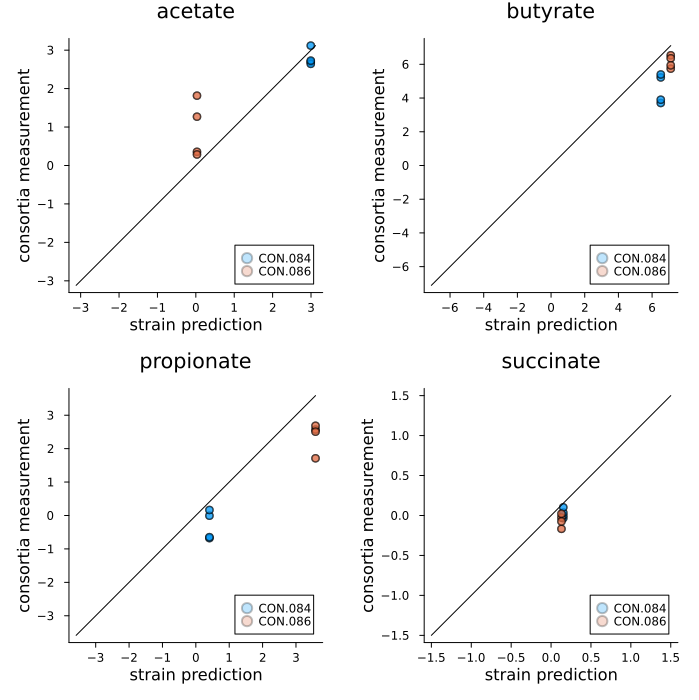

In [218]:
p1 = @df mrgdf scatter(:Acetate, :acetate, group=:con_id, alpha=.25, title="acetate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Acetate, mrgdf.acetate)), widen=true)
p2 = @df mrgdf scatter(:Butyrate, :butyrate, group=:con_id, alpha=.25, title="butyrate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Butyrate, mrgdf.butyrate)), widen=true)
p3 = @df mrgdf scatter(:Propionate, :propionate, group=:con_id, alpha=.25, title="propionate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Propionate, mrgdf.propionate)), widen=true)
p4 = @df mrgdf scatter(:Succinate, :succinate, group=:con_id, alpha=.25, title="succinate", ratio=1, )
# plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Succinate, mrgdf.succinate)), widen=true)
plot!(identity, c=:black, lims=lims=(-1.5, 1.5), widen=true)
plot(p1, p2, p3, p4, layout = grid(2,2), size=(700,700), legend=:bottomright, xlabel="strain prediction", ylabel="consortia measurement")

In [219]:
pltdf = mrgdf |>
df -> groupby(df, :con_id) |>
df -> combine(df, 
    [5:8..., 14:17...] .=> mean,
    [5:8..., 14:17...] .=> std,
    )

2×17 DataFrame
 Row │ con_id   Acetate_mean  Butyrate_mean  Propionate_mean  Succinate_mean   ⋯
     │ String   Float64       Float64        Float64          Float64          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CON.084     2.99394          6.51655         0.407504        0.153073   ⋯
   2 │ CON.086     0.0298967        7.10884         3.58584         0.13039
                                                              12 columns omitted

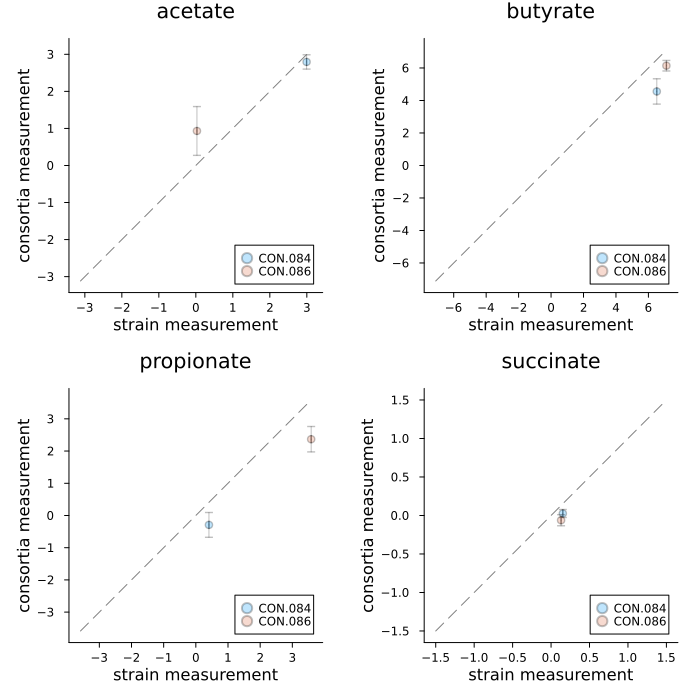

In [221]:
p1 = @df pltdf scatter(:Acetate_mean, :acetate_mean, xerror=:Acetate_std, yerror=:acetate_std, group=:con_id, alpha=.25, title="acetate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Acetate, mrgdf.acetate)), widen=1.1)
p2 = @df pltdf scatter(:Butyrate_mean, :butyrate_mean, xerror=:Butyrate_std, yerror=:butyrate_std, group=:con_id, alpha=.25, title="butyrate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Butyrate, mrgdf.butyrate)), widen=1.1)
p3 = @df pltdf scatter(:Propionate_mean, :propionate_mean, xerror=:Propionate_std, yerror=:propionate_std, group=:con_id, alpha=.25, title="propionate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Propionate, mrgdf.propionate)), widen=1.1)
p4 = @df pltdf scatter(:Succinate_mean, :succinate_mean, xerror=:Succinate_std, yerror=:succinate_std, group=:con_id, alpha=.25, title="succinate", ratio=1)
# plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Succinate, mrgdf.succinate)), widen=1.1)
plot!(identity, c=:grey, linestyle=:dash, lims=(-1.5, 1.5), widen=1.1)
plot(p1, p2, p3, p4, layout = grid(2,2), size=(700,700), legend=:bottomright, xlabel="strain measurement", ylabel="consortia measurement")

## E. rectale preds

In [222]:
occursin.("prauznitzii", biobank.obs.species_ncbi) |> any

false

In [223]:
occursin.("Faecalibacterium", biobank.obs.genus_ncbi) |> any

false

In [224]:
biobank.obs[occursin.("Oscillospiraceae", biobank.obs.family_ncbi), :]

4×25 DataFrame
 Row │ ID         first_strain_id                   strain_id  seq_id    donor ⋯
     │ String     String                            String     String    Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ MSK.9.16   MSK.9.16_Flavonifractor_plautii   MSK.9.16   TM427     FC000 ⋯
   2 │ MSK.14.42  MSK.14.42_Flavonifractor_plautii  MSK.14.42  MSK14_42  FC001
   3 │ MSK.5.7    MSK.5.7_Flavonifractor_plautii    MSK.5.7    MSK5_7    FC000
   4 │ MSK.6.9    MSK.6.9_Ruminococcus_albus        MSK.6.9    TM225     FC000
                                                              21 columns omitted

In [225]:
rectale_ids = findall(occursin.("rectale", bbobs_trn.species_ncbi))
mskdf = subset(oofpreds,
    :row_id => x->x.∈Ref(rectale_ids),
    :metabolite_name => x->x.∈Ref(["Acetate", "Butyrate", "Propionate", "Succinate"]),
) |>
df -> unstack(df, [:row_id, :resample], :metabolite_name, :preds) |>
df -> sort(df, [:row_id, :resample])
mskdf.msk_id = bbobs_trn.ID[mskdf.row_id]
mskdf;

In [226]:
basedf = DataFrame(con_id="CON.119", msk_id=unique(mskdf.msk_id))
mrgdf = leftjoin(basedf, mskdf, on = :msk_id)
mrgdf = leftjoin(mrgdf, con_log2fc_df, on=:con_id => :CON_ID);

In [227]:
mrgdf

200×17 DataFrame
 Row │ con_id   msk_id     row_id  resample  Acetate     Butyrate  Propionate  ⋯
     │ String   String     Int64?  Int64?    Float64?    Float64?  Float64?    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CON.119  MSK.9.13      110         1   0.880069    5.91158    0.292969  ⋯
   2 │ CON.119  MSK.9.13      110         1   0.880069    5.91158    0.292969
   3 │ CON.119  MSK.9.13      110         2  -0.0903403   5.86217    0.241252
   4 │ CON.119  MSK.9.13      110         2  -0.0903403   5.86217    0.241252
   5 │ CON.119  MSK.9.13      110         3   0.889287    5.86037    0.245026  ⋯
   6 │ CON.119  MSK.9.13      110         3   0.889287    5.86037    0.245026
   7 │ CON.119  MSK.9.13      110         4   0.883825    5.85795    0.249131
   8 │ CON.119  MSK.9.13      110         4   0.883825    5.85795    0.249131
  ⋮  │    ⋮         ⋮        ⋮        ⋮          ⋮          ⋮          ⋮       ⋱
 194 │ CON.119  MSK.22.92     213         2   0.58215     5.87886    0.149134  ⋯
 195 │ CON.119  MSK.22.92     213         3   0.466785    5.77806    0.158644
 196 │ CON.119  MSK.22.92     213         3   0.466785    5.77806    0.158644
 197 │ CON.119  MSK.22.92     213         4   0.696096    5.90145    0.116138
 198 │ CON.119  MSK.22.92     213         4   0.696096    5.90145    0.116138  ⋯
 199 │ CON.119  MSK.22.92     213         5   0.695983    5.89634    0.170071
 200 │ CON.119  MSK.22.92     213         5   0.695983    5.89634    0.170071
                                                 10 columns and 185 rows omitted

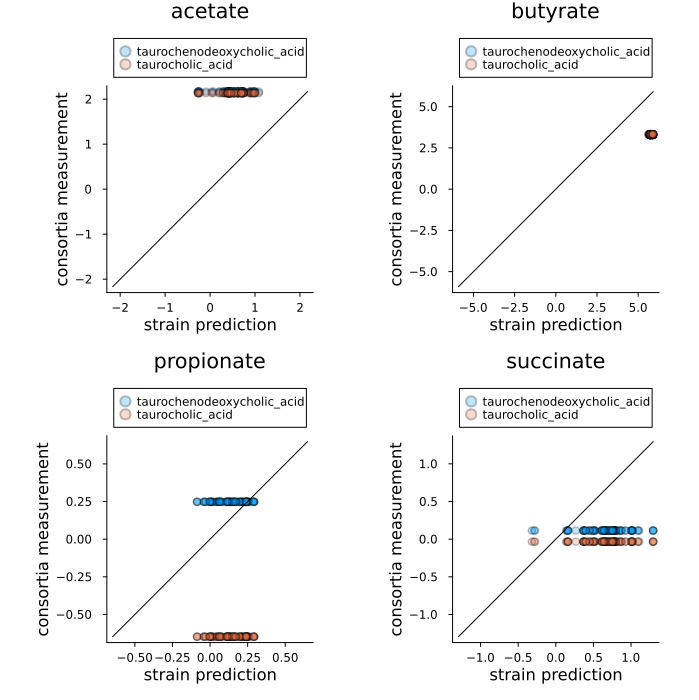

In [234]:
p1 = @df mrgdf scatter(:Acetate, :acetate, group=:Input_Condition, alpha=.25, title="acetate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Acetate, mrgdf.acetate)), widen=true)
p2 = @df mrgdf scatter(:Butyrate, :butyrate, group=:Input_Condition, alpha=.25, title="butyrate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Butyrate, mrgdf.butyrate)), widen=true)
p3 = @df mrgdf scatter(:Propionate, :propionate, group=:Input_Condition, alpha=.25, title="propionate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Propionate, mrgdf.propionate)), widen=true)
p4 = @df mrgdf scatter(:Succinate, :succinate, group=:Input_Condition, alpha=.25, title="succinate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Succinate, mrgdf.succinate)), widen=true)
plot(p1, p2, p3, p4, layout = grid(2,2), size=(700,700), legend=:outertop, xlabel="strain prediction", ylabel="consortia measurement")

In [174]:
pltdf = mrgdf |>
df -> groupby(df, :con_id) |>
df -> combine(df, 
    [5:8..., 14:17...] .=> mean,
    [5:8..., 14:17...] .=> std,
    )

1×17 DataFrame
 Row │ con_id   Acetate_mean  Butyrate_mean  Propionate_mean  Succinate_mean   ⋯
     │ String   Float64       Float64        Float64          Float64          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CON.119       0.50317        5.79273         0.133566        0.662992   ⋯
                                                              12 columns omitted

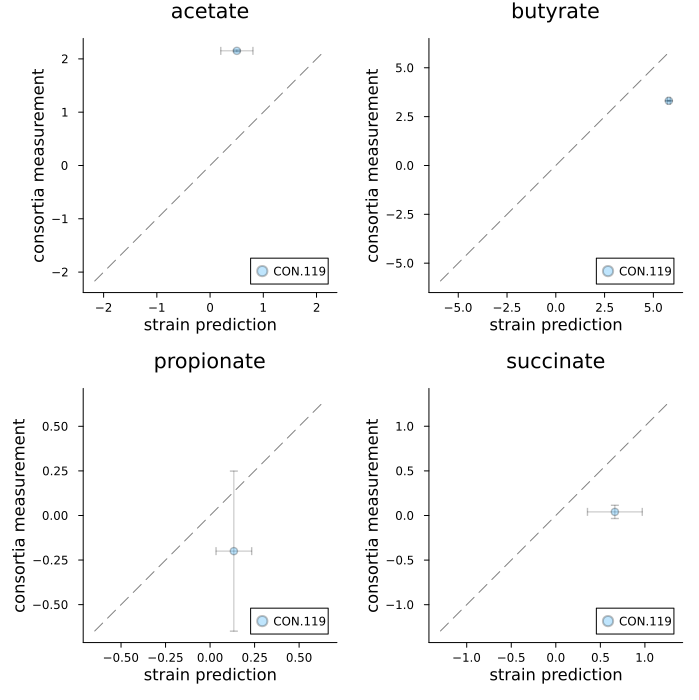

In [175]:
p1 = @df pltdf scatter(:Acetate_mean, :acetate_mean, xerror=:Acetate_std, yerror=:acetate_std, group=:con_id, alpha=.25, title="acetate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Acetate, mrgdf.acetate)), widen=1.1)
p2 = @df pltdf scatter(:Butyrate_mean, :butyrate_mean, xerror=:Butyrate_std, yerror=:butyrate_std, group=:con_id, alpha=.25, title="butyrate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Butyrate, mrgdf.butyrate)), widen=1.1)
p3 = @df pltdf scatter(:Propionate_mean, :propionate_mean, xerror=:Propionate_std, yerror=:propionate_std, group=:con_id, alpha=.25, title="propionate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Propionate, mrgdf.propionate)), widen=1.1)
p4 = @df pltdf scatter(:Succinate_mean, :succinate_mean, xerror=:Succinate_std, yerror=:succinate_std, group=:con_id, alpha=.25, title="succinate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Succinate, mrgdf.succinate)), widen=1.1)
plot(p1, p2, p3, p4, layout = grid(2,2), size=(700,700), legend=:bottomright, xlabel="strain prediction", ylabel="consortia measurement")

## E. rectale preds

In [176]:
occursin.("prauznitzii", biobank.obs.species_ncbi) |> any

false

In [177]:
occursin.("Faecalibacterium", biobank.obs.genus_ncbi) |> any

false

In [178]:
biobank.obs[occursin.("Oscillospiraceae", biobank.obs.family_ncbi), :]

4×25 DataFrame
 Row │ ID         first_strain_id                   strain_id  seq_id    donor ⋯
     │ String     String                            String     String    Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ MSK.9.16   MSK.9.16_Flavonifractor_plautii   MSK.9.16   TM427     FC000 ⋯
   2 │ MSK.14.42  MSK.14.42_Flavonifractor_plautii  MSK.14.42  MSK14_42  FC001
   3 │ MSK.5.7    MSK.5.7_Flavonifractor_plautii    MSK.5.7    MSK5_7    FC000
   4 │ MSK.6.9    MSK.6.9_Ruminococcus_albus        MSK.6.9    TM225     FC000
                                                              21 columns omitted

In [180]:
rectale_ids = findall(occursin.("rectale", bbobs_trn.species_ncbi))
mskdf = subset(oofpreds,
    :row_id => x->x.∈Ref(rectale_ids),
    :metabolite_name => x->x.∈Ref(["Acetate", "Butyrate", "Propionate", "Succinate"]),
) |>
df -> unstack(df, [:row_id, :resample], :metabolite_name, :truth) |>
df -> sort(df, [:row_id, :resample])
mskdf.msk_id = bbobs_trn.ID[mskdf.row_id]
mskdf;

In [181]:
basedf = DataFrame(con_id="CON.119", msk_id=unique(mskdf.msk_id))
mrgdf = leftjoin(basedf, mskdf, on = :msk_id)
mrgdf = leftjoin(mrgdf, con_log2fc_df, on=:con_id => :CON_ID);

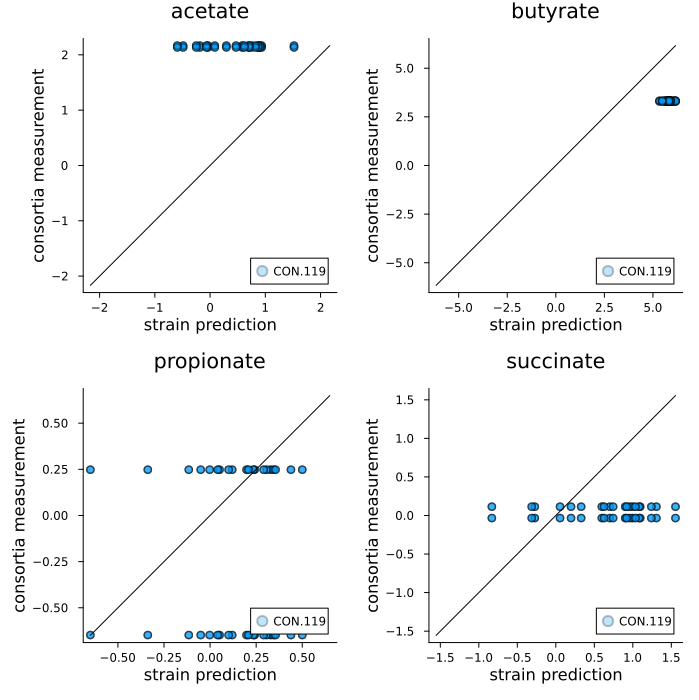

In [182]:
p1 = @df mrgdf scatter(:Acetate, :acetate, group=:con_id, alpha=.25, title="acetate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Acetate, mrgdf.acetate)), widen=true)
p2 = @df mrgdf scatter(:Butyrate, :butyrate, group=:con_id, alpha=.25, title="butyrate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Butyrate, mrgdf.butyrate)), widen=true)
p3 = @df mrgdf scatter(:Propionate, :propionate, group=:con_id, alpha=.25, title="propionate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Propionate, mrgdf.propionate)), widen=true)
p4 = @df mrgdf scatter(:Succinate, :succinate, group=:con_id, alpha=.25, title="succinate", ratio=1)
plot!(identity, c=:black, lims=getlims(vcat(mrgdf.Succinate, mrgdf.succinate)), widen=true)
plot(p1, p2, p3, p4, layout = grid(2,2), size=(700,700), legend=:bottomright, xlabel="strain prediction", ylabel="consortia measurement")

In [183]:
pltdf = mrgdf |>
df -> groupby(df, :con_id) |>
df -> combine(df, 
    [5:8..., 14:17...] .=> mean,
    [5:8..., 14:17...] .=> std,
    )

1×17 DataFrame
 Row │ con_id   Acetate_mean  Butyrate_mean  Propionate_mean  Succinate_mean   ⋯
     │ String   Float64       Float64        Float64          Float64          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CON.119       0.42588        5.81417         0.130227        0.646151   ⋯
                                                              12 columns omitted

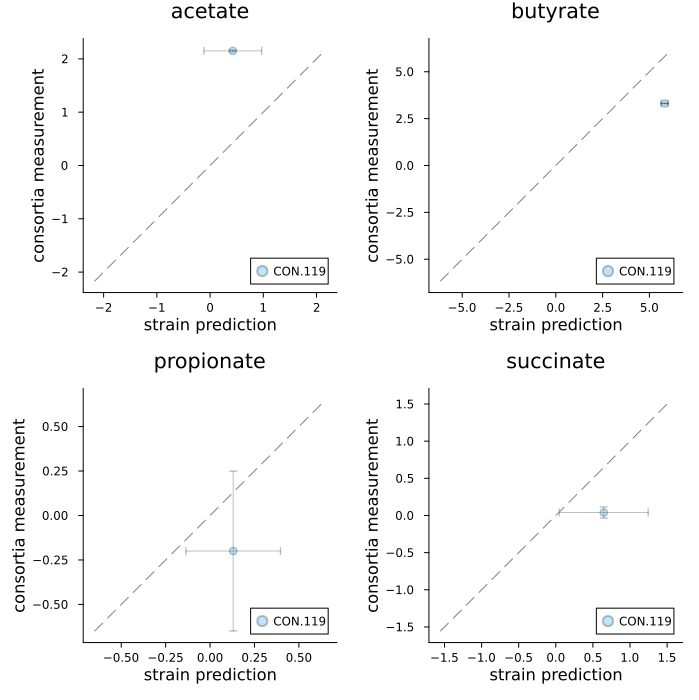

In [184]:
p1 = @df pltdf scatter(:Acetate_mean, :acetate_mean, xerror=:Acetate_std, yerror=:acetate_std, group=:con_id, alpha=.25, title="acetate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Acetate, mrgdf.acetate)), widen=1.1)
p2 = @df pltdf scatter(:Butyrate_mean, :butyrate_mean, xerror=:Butyrate_std, yerror=:butyrate_std, group=:con_id, alpha=.25, title="butyrate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Butyrate, mrgdf.butyrate)), widen=1.1)
p3 = @df pltdf scatter(:Propionate_mean, :propionate_mean, xerror=:Propionate_std, yerror=:propionate_std, group=:con_id, alpha=.25, title="propionate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Propionate, mrgdf.propionate)), widen=1.1)
p4 = @df pltdf scatter(:Succinate_mean, :succinate_mean, xerror=:Succinate_std, yerror=:succinate_std, group=:con_id, alpha=.25, title="succinate", ratio=1)
plot!(identity, c=:grey, linestyle=:dash, lims=getlims(vcat(mrgdf.Succinate, mrgdf.succinate)), widen=1.1)
plot(p1, p2, p3, p4, layout = grid(2,2), size=(700,700), legend=:bottomright, xlabel="strain prediction", ylabel="consortia measurement")